# Identify a MHW

In [1]:
import xarray as xr
import json
import gcsfs
import numpy as np
import cmocean

import matplotlib.pyplot as plt
import dask

In [2]:
import json
import gcsfs

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

ds_sst = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/sst_trop_ds.zarr'))

In [3]:
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    sst = ds_sst.sst

In [4]:
sst

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<open_dataset-sst, shape=(50309, 109, 401), dtype=float32, chunksize=(45, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

# 90$^{th}$ percentile

In [5]:
q90 = sst.chunk({'time':-1}).quantile(0.9, dim='time')

In [6]:
q90

<xarray.DataArray 'sst' (latitude: 109, longitude: 401)>
dask.array<getitem, shape=(109, 401), dtype=float64, chunksize=(109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
    quantile   float64 0.9

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


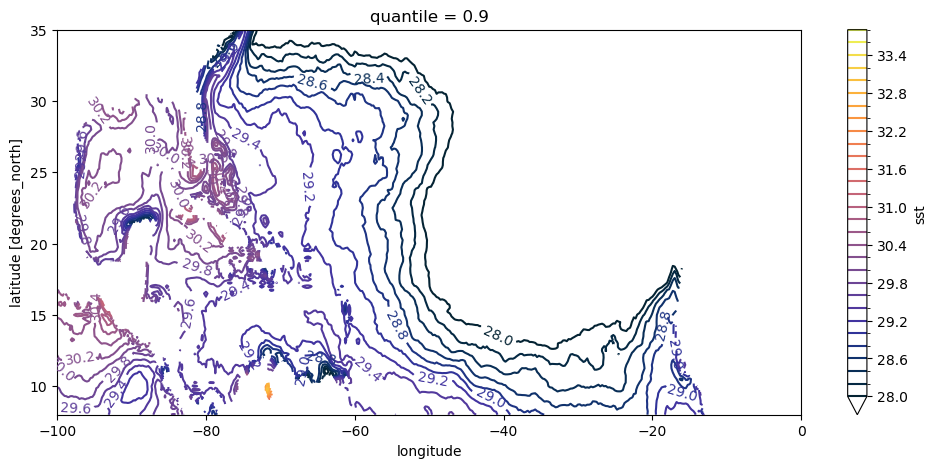

In [7]:
theta_levs = np.arange(28,34,0.2)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contour(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)
plt.clabel(C);

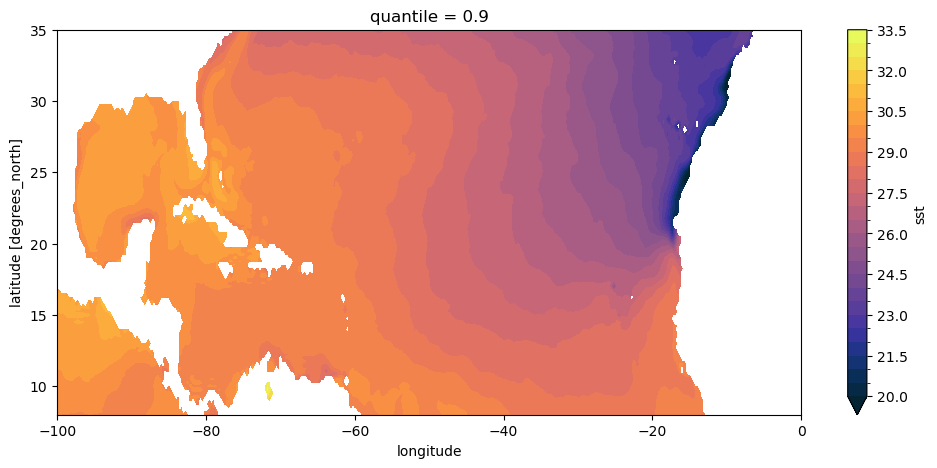

In [10]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = q90.plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

# Find temp above 90$^{th}$ percentile threshold

In [8]:
#daily clim
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):

clim = sst.groupby('time.dayofyear').mean('time')
clim_std = sst.groupby('time.dayofyear').std('time')
anom = sst.groupby('time.dayofyear') - clim

#monthly clim
mo_clim = sst.groupby('time.month').mean('time')
mo_clim_std = sst.groupby('time.month').std('time')
mo_anom = sst.groupby('time.month') - mo_clim

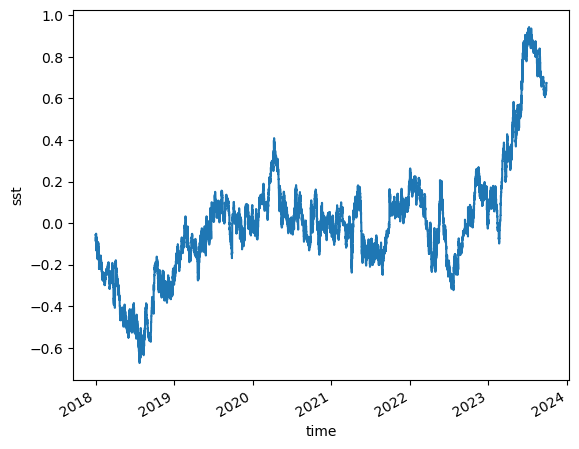

In [29]:
anom.mean(['latitude', 'longitude']).plot()

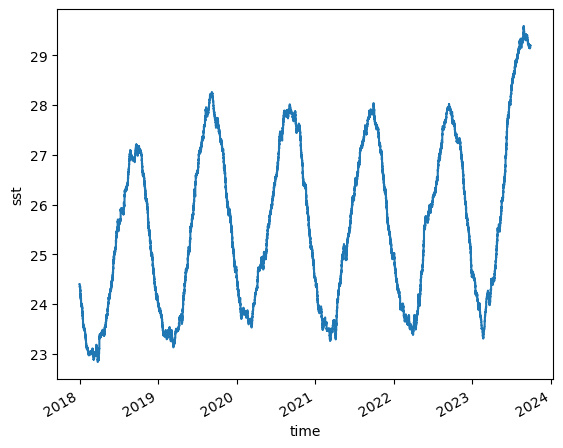

In [33]:
(sst+anom).mean(['latitude', 'longitude']).plot(label='sst+anom')

In [10]:
mo_anom

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<sub, shape=(50309, 109, 401), dtype=float32, chunksize=(45, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00
    month      (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 9 9 9 9 9 9 9 9 9 9 9 9

In [41]:
#above_thr = mo_anom.where(mo_anom>=q90, other=np.nan)#.chunk({'time':12577})
#above_thr = anom.where(anom>=q90, other=np.nan)
above_thr = clim.where(clim>=q90, other=np.nan)
above_thr_std = (clim+clim_std).where((clim+clim_std)>=q90, other=np.nan)
above_thr_anom = (sst+anom).where((sst+anom)>=q90, other=np.nan).drop(('dayofyear', 'quantile'))

In [42]:
above_thr

<xarray.DataArray 'sst' (dayofyear: 366, latitude: 109, longitude: 401)>
dask.array<where, shape=(366, 109, 401), dtype=float32, chunksize=(1, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
    quantile   float64 0.9

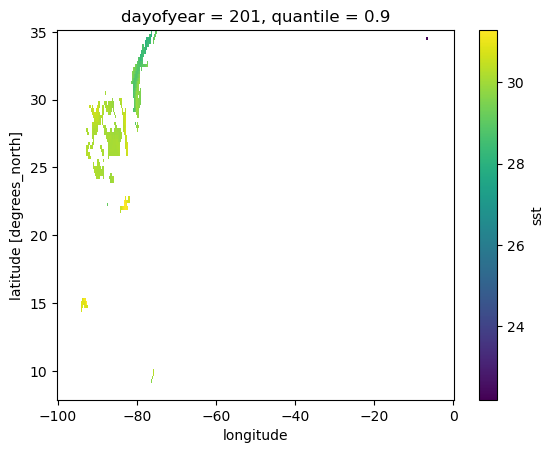

In [15]:
above_thr.isel(dayofyear=200).plot()

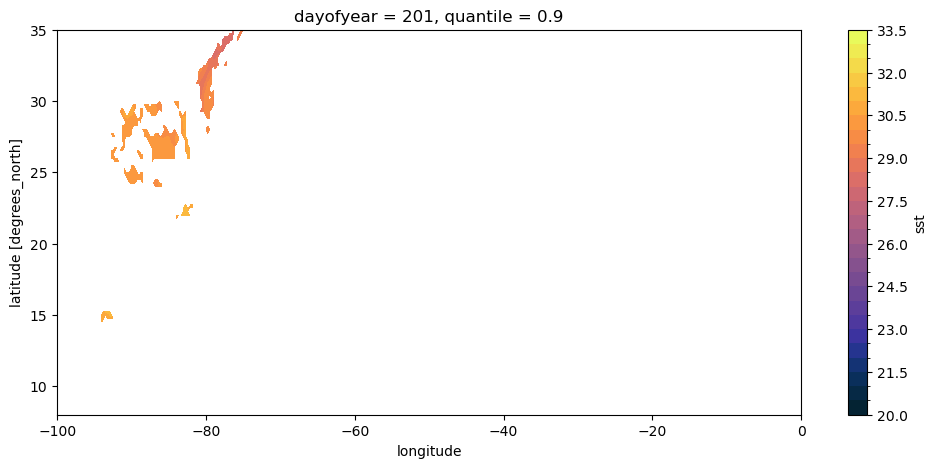

In [18]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = above_thr.isel(dayofyear=200).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, ax=ax, add_colorbar=True)

In [43]:
above_thr_anom

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<where, shape=(50309, 109, 401), dtype=float32, chunksize=(24, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

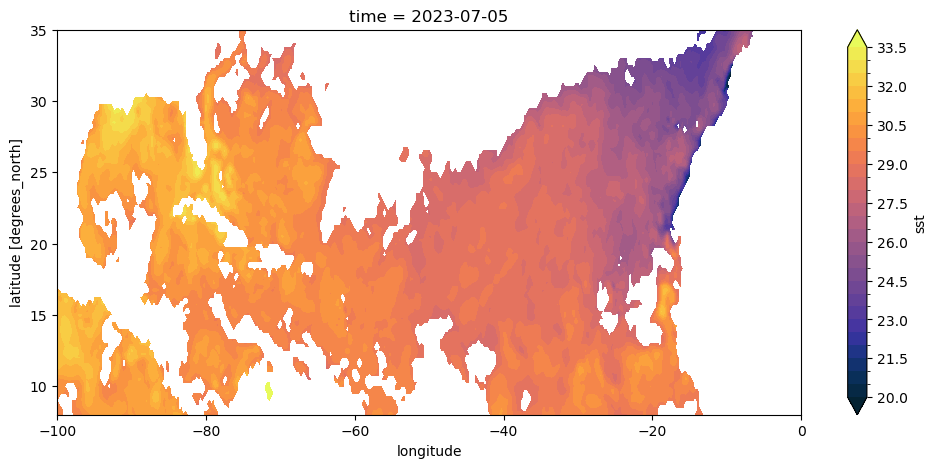

In [48]:
theta_levs = np.arange(20,34,0.5)

fig, ax = plt.subplots(figsize=(12,5))
C = above_thr_anom.sel(time='2023-07-05', method='nearest').plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                          ax=ax, add_colorbar=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))


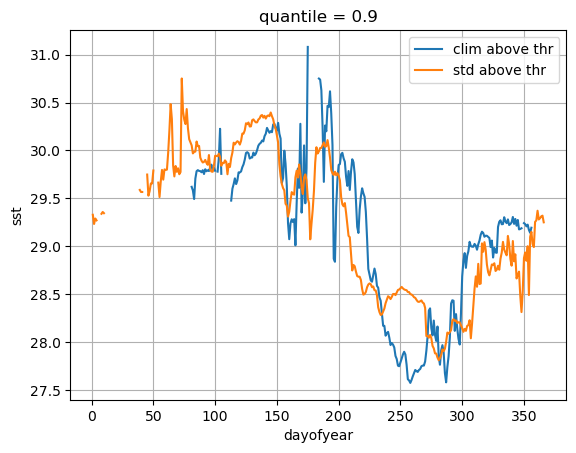

In [49]:
above_thr.mean(['latitude', 'longitude']).plot(label='clim above thr')
above_thr_std.mean(['latitude', 'longitude']).plot(label='std above thr')
plt.legend()
plt.grid();

In [ ]:
dty = above_thr_anom.time.groupby('time.year').count()
dt2023 = above_thr_anom.sel(time=slice('2023-01', '2023-09')).time.groupby('time.month').count()

In [ ]:
dty

In [ ]:
dt2023

# Movie

In [50]:
above_thr_anom

<xarray.DataArray 'sst' (time: 50309, latitude: 109, longitude: 401)>
dask.array<where, shape=(50309, 109, 401), dtype=float32, chunksize=(24, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-09-28T04:00:00

In [51]:
resampled = above_thr_anom.resample(time='D').mean()

In [52]:
resampled

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
dask.array<transpose, shape=(2097, 109, 401), dtype=float32, chunksize=(1, 109, 401), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [53]:
loaded_sst = resampled.compute()

In [54]:
loaded_sst

<xarray.DataArray 'sst' (time: 2097, latitude: 109, longitude: 401)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 8.0 8.25 8.5 8.75 ... 34.25 34.5 34.75 35.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 -99.25 ... -0.5 -0.25 0.0
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2023-09-28

In [56]:
from xmovie import Movie
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [57]:
import cmocean

def contour_surf(da, fig, tt, *args, **kwargs):
    
    ax = fig.subplots()
    theta_levs = np.arange(20,34,0.5)

    #C = loaded_sst.isel(time=tt).plot.contour(colors='yellow', levels=[29], ax=ax)
    #ax.clabel(C)
    
    Cf = da.isel(time=tt).plot.contourf(colors=cmocean.cm.thermal, levels=theta_levs, 
                                                                ax=ax, add_colorbar=True)

    
    return ax, Cf

(<Axes: title={'center': 'time = 2023-09-24'}, xlabel='longitude', ylabel='latitude [degrees_north]'>,
 <matplotlib.contour.QuadContourSet at 0x7f3235bb6f80>)

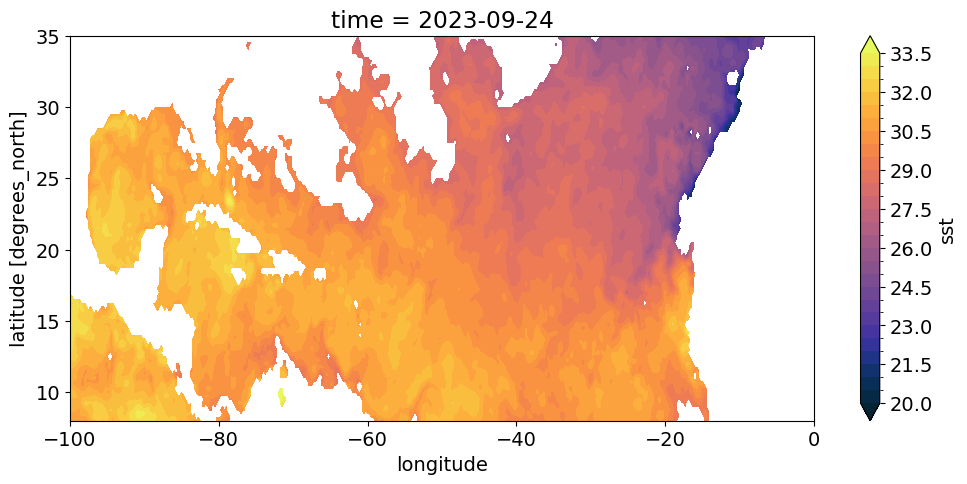

In [61]:
fig = plt.figure(figsize=(12, 5))

contour_surf(loaded_sst, fig, -5)

In [62]:
sst = Movie(loaded_sst, contour_surf, 
                   input_check=False)

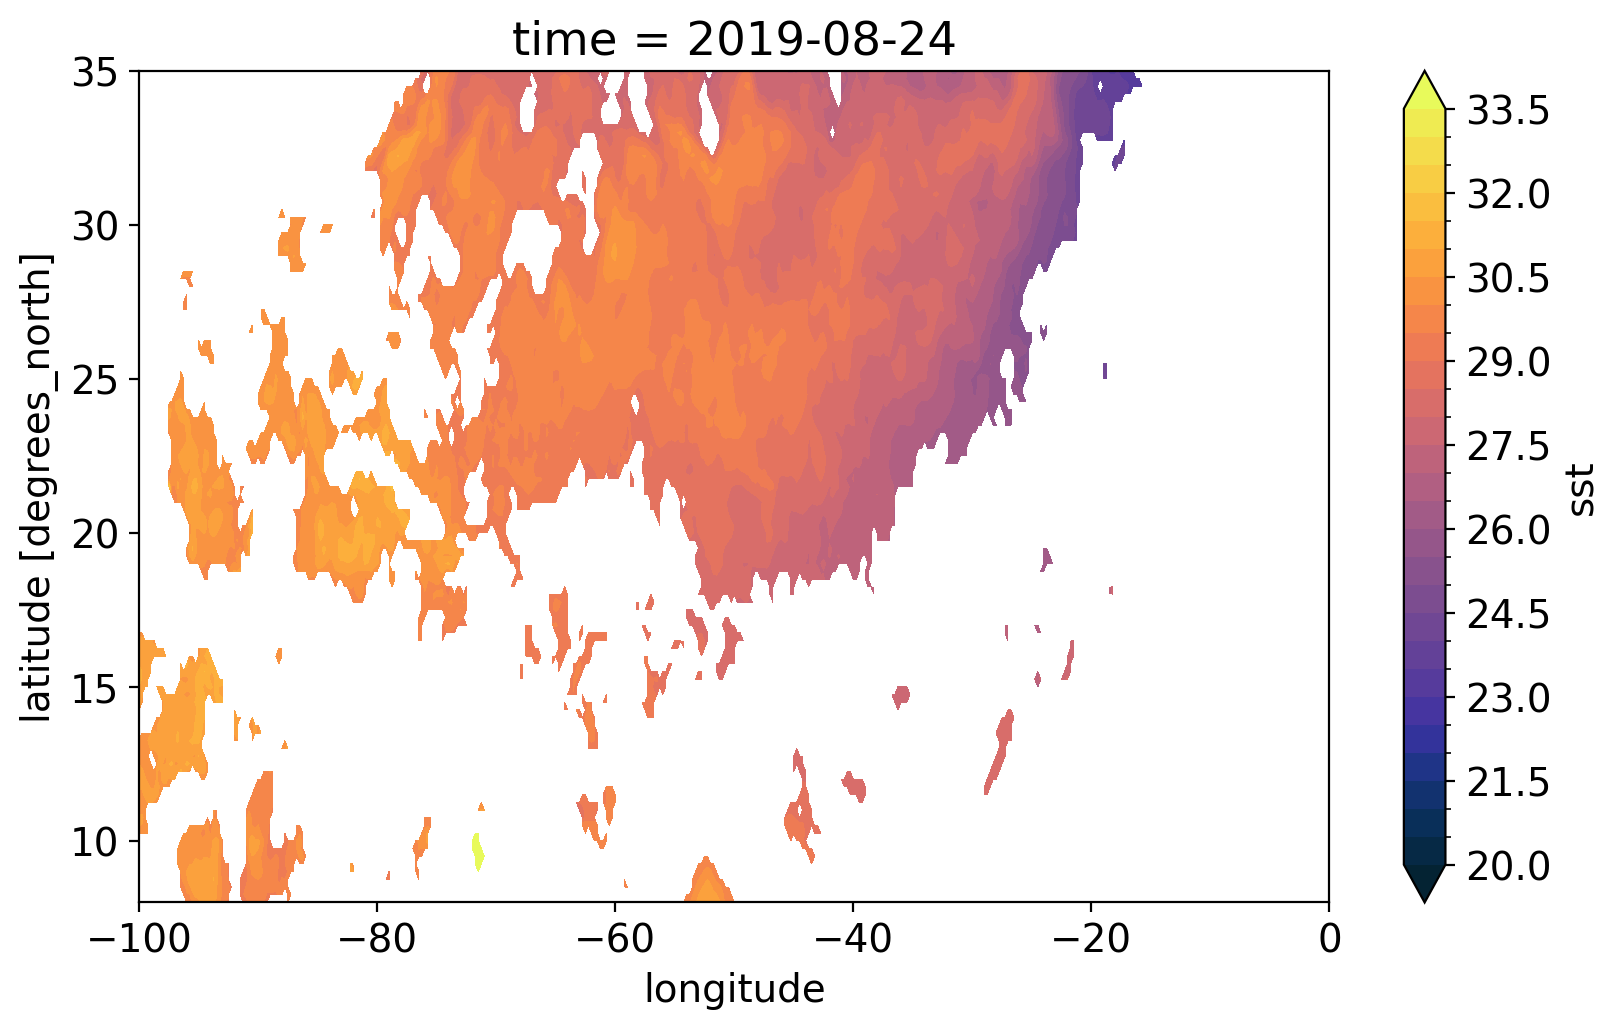

In [63]:
sst.preview(600)

In [64]:
#save sstmovie
sst.save('sst_above_thr_daily.mp4', progress=True, overwrite_existing=True)

  0%|          | 0/2097 [00:00<?, ?it/s]

Movie created at sst_above_thr_daily.mp4


In [44]:
client.close()
cluster.close()